# Predicting the Risk of Diabetes
#### Group 14 - Angela Yang, Tina Chen, Tom Cui, Yiyang Zhang

## Introduction: ##

Diabetes is a chronic health condition where blood glucose is unable to enter cells due to the lack of insulin facilitating this exchange (NIDDK, 2016). With diabetes being one of the top causes of death in North America (CDC, 2022), the need to determine the best health indicators becomes increasingly important for the correct diagnosis of diabetes. 

For our project, we will try to answer this predictive question: Given the health profile of a patient, how accurate can our classification model predict potential diabetes cases based on the selected explanatory variables?

We will perform our analysis using a dataset from Kaggle, originally from the National Institute of Diabetes and Digestive and Kidney Diseases. It contains a variety of health indicators including pregnancies, glucose, blood pressure, skin thickness, insulin, BMI, diabetes pedigree function, age, and outcome, which are used to determine whether the individual was diagnosed with diabetes based on these indicators. For our classification model, we chose to use glucose, blood pressure, insulin, and BMI as our predictor variables to make a diagnosis.
- Glucose is a specific type of sugar and is measured by the concentration present in the blood
- Blood pressure it the measure of pressure in blood vessels
- Insulin is a hormone that regulates the levels of glucose in the blood
- BMI stands for Body Mass Index that measures the body fat of a person based on their weight and height

#### Figure & Table Legends
- Table 1: Original data frame
- Table 2: Tidied data frame
- Table 3: Summary statistics (min, mean, max) for each variable
- Table 4: Accuracy results from forward selection process
- Figure 1: Predictor selection vs. accuracy
- Figure 2: Initial visualization using box plots
- Figure 3: k value vs. accuracy 
- Table 5: Result metrics of model predictions
- Figure 4: Final visualization using heat map

## Methods & Results: ##
#### Project Explanation ####
This project will use classification with k-nearest neighbors to predict potential diabetes cases based on a patient's BMI, blood glucose levels, blood pressure, and insulin levels. 

Our methodology is divided into the following sections:
1. Preliminary exploratory data analysis
2. Building the classifier
3. Final visualization of results

### 1. Preliminary Exploratory Data Analysis
#### Loading and Tidying the Data
To start, we load in the external libraries needed to implement functions into our code that do not load by default. Since our data set is comma separated, we use the read_csv() function to read the file into R.

In [2]:
#disabled warning messages
defaultW <- getOption("warn")
options(warn = -1)

#Attaching libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
library(readr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
#Load in the data using its URL
diabetes_data <- read_csv(url("https://raw.githubusercontent.com/angela-yang349/dsci-100-2022w2-group-14-007/main/diabetes.csv"))

#Table 1
print("Table 1")
head(diabetes_data)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1"


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


Next, we tidied the data in a few ways:
- Change the outcome column from a character type to a factor type because the "0" and "1" represent the absence and presence of diabetes, respectively 
- Get rid of all rows that contain 0's (except for pregnancies and outcome) as those indicate observations with missing data so they will not be used in our analysis

In [80]:
#Tidying the data
diabetes_data_processed <- diabetes_data |>
    filter(Pregnancies!=0 & Glucose !=0 & BloodPressure !=0 & SkinThickness !=0 & Insulin !=0) |>
    mutate(Outcome = as_factor(Outcome))

#Table 2
print("Table 2")
head(diabetes_data_processed)

#Check the number of rows before and after wrangling
nrow(diabetes_data)
nrow(diabetes_data_processed)

[1] "Table 2"


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<fct>
1,1,89,66,23,94,28.1,0.167,21,0
2,3,78,50,32,88,31.0,0.248,26,1
3,2,197,70,45,543,30.5,0.158,53,1
4,1,189,60,23,846,30.1,0.398,59,1
5,5,166,72,19,175,25.8,0.587,51,1
6,1,103,30,38,83,43.3,0.183,33,0


[1] 768

[1] 336

Deleting rows decreases our data frame size from 768 to 336 but 336 rows is still a suitable size to train and test our classification model.

#### Compiling Initial Statistics
We calculated summary statistics including min, mean, and max, in order to gain information about the observations in the data set. Before performing the summary, we made sure to change all columns, except for the "Outcome" column, to a numeric type. The values are put into "Table 3" which shows us the range for each variable in the data set. This will be useful for the classification as it sets the scale and range of the numbers that will be used in the training data.

In [5]:
#Mutating column type
diabetes_data_summary <- diabetes_data_processed |>
  mutate_all(~ifelse(is.na(.), NA, as.numeric(as.character(.))))

#Summary statistics for min
diabetes_min <- diabetes_data_summary |>
    map_df(min, na.rm = TRUE) |>
    round(digits = 3) |>
    pivot_longer(cols = Pregnancies:Outcome,
                 names_to = "variables",
                 values_to = "min")
#Summary statistics for mean
diabetes_mean <- diabetes_data_summary |>
    map_df(mean, na.rm = TRUE) |>
    round(digits = 3) |>
    pivot_longer(cols = Pregnancies:Outcome,
                 names_to = "variables",
                 values_to = "mean")
#Summary statistics for max
diabetes_max <- diabetes_data_summary |>
    map_df(max, na.rm = TRUE) |>
    round(digits = 3) |>
    pivot_longer(cols = Pregnancies:Outcome,
                 names_to = "variables",
                 values_to = "max")

#Table 3
diabetes_summary <- diabetes_min |>
    full_join(diabetes_mean) |>
    full_join(diabetes_max)
print("Table 3")
diabetes_summary

Joining, by = "variables"
Joining, by = "variables"


[1] "Table 3"


variables,min,mean,max
<chr>,<dbl>,<dbl>,<dbl>
Pregnancies,1.000,3.851,17.000
Glucose,56.000,122.280,197.000
BloodPressure,24.000,70.244,110.000
SkinThickness,7.000,28.664,52.000
Insulin,15.000,155.348,846.000
BMI,18.200,32.297,57.300
DiabetesPedigreeFunction,0.085,0.519,2.329
Age,21.000,31.836,81.000
Outcome,0.000,0.330,1.000


From the table above, we can see that there is a variety of scaling for the variables. Some observations we noticed were that insulin has the largest range in value while diabetes pedigree function has the smallest range in value. This could potentially impact our data analysis which shows that scaling is needed to preprocess this data.

#### Assessing and Choosing Predictors
Available Predictors and Units:
1. Pregnancies (number of times)
2. Glucose (mg/dL)
3. Blood Pressure (mm Hg)
4. Skin Thickness (mm)
5. Insulin (mu U/ml)
6. BMI (kg/m^2)
7. Diabetes pedigree function
8. Age (year)
9. Outcome

We will be using the forward selection method to choose which of these predictors will give us the highest accuracy for our model.

In [6]:
set.seed(1400)

#split the data into training and testing set
df_split <- initial_split(diabetes_data_processed,prop=0.75, strata = Outcome)
diabetes_training <- training(df_split)
diabetes_testing <- testing(df_split)

In [53]:
set.seed(1400)

#Names of predictor variables
names <- colnames(diabetes_training |> select(-Outcome))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric()) 

#Model specifications
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |> 
    set_mode("classification") 
#Performing cross-validation
diabetes_vfold <- vfold_cv(diabetes_training, v = 5, strata = Outcome) 

#Forward Selection method
n_total <- length(names) 
selected <- c() 

for (i in 1:n_total) { 
    accs <- list() 
    models <- list() 
    for (j in 1:length(names)) { 
        preds_new <- c(selected, 
                       names[[j]]) 
        model_string <- paste("Outcome", 
                              "~", paste(preds_new, 
                                         collapse="+")) 

diabetes_recipe <- recipe(as.formula(model_string), data = diabetes_training) |> 
        step_scale(all_predictors()) |> 
        step_center(all_predictors()) 
        
acc <- workflow() |> 
        add_recipe(diabetes_recipe) |> 
        add_model(knn_spec) |> 
        tune_grid(resamples = diabetes_vfold, grid = 20) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
      add_row(size = i,
              model_string = models[[jstar]],
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [58]:
#Table 4: Accuracy table for each combination of predictors
accuracies_diff <- accuracies|>
    mutate(diff = 100*(accuracy-lag(accuracy)))
print("Table 4")
accuracies_diff

#Chosen model specification for classification
model = as.formula("Outcome ~ Glucose + Age + Pregnancies + Insulin")
model

[1] "Table 4"


size,model_string,accuracy,diff
<int>,<chr>,<dbl>,<dbl>
1,Outcome ~ Glucose,0.7693477,NA
2,Outcome ~ Glucose+Age,0.7935174,2.4169668
3,Outcome ~ Glucose+Age+Pregnancies,0.7975990,0.4081633
4,Outcome ~ Glucose+Age+Pregnancies+Insulin,0.8013605,0.3761505
5,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI,0.7812725,-2.0088035
6,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction,0.7931973,1.1924770
7,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction+BloodPressure,0.7690276,-2.4169668
8,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction+BloodPressure+SkinThickness,0.7688675,-0.0160064


Outcome ~ Glucose + Age + Pregnancies + Insulin

From this forward selection process, it is found that using 4 predictor variables of glucose, age, pregnancies, and insulin will give us the highest accuracy of 0.80 for our model. This can be further visualized in a graph that displays the amount of predictors vs. accuracy.

[1] "Figure 1"


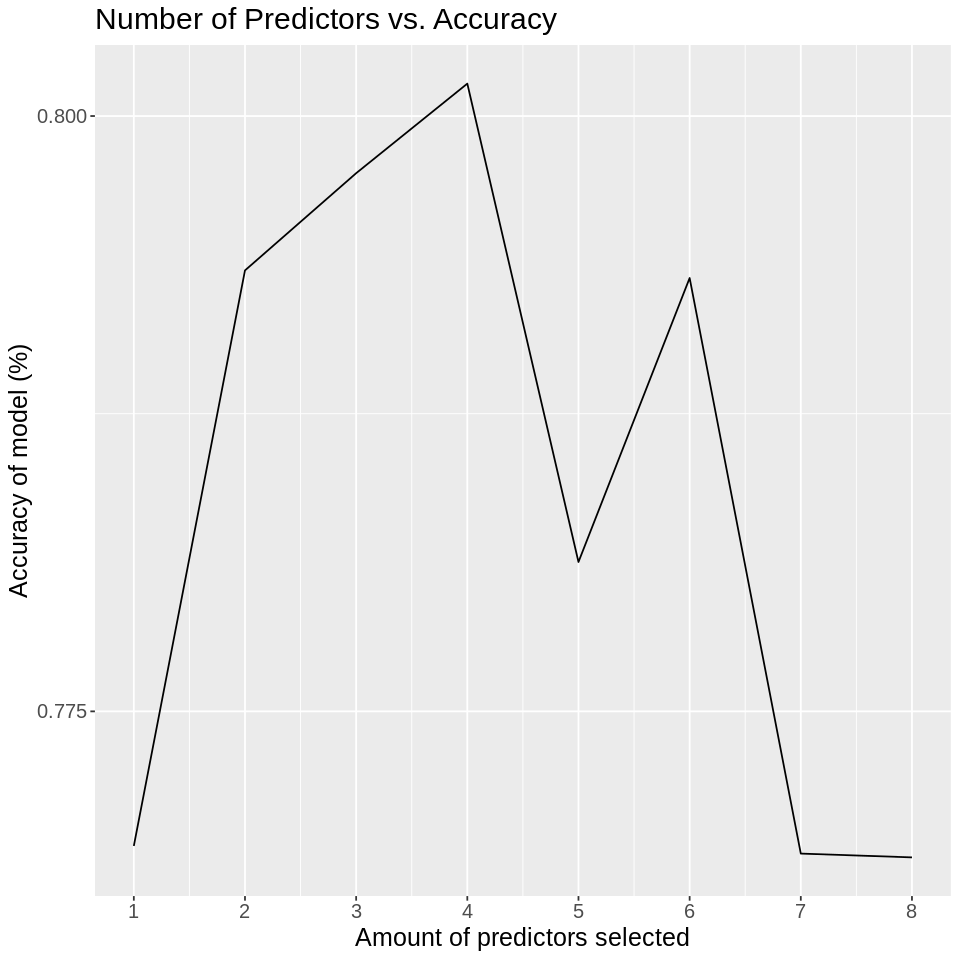

In [84]:
options(repr.plot.width = 8, repr.plot.height = 8)

#Visualization for number of predictors vs. accuracy
model_selection_plot <- accuracies_diff |>
  ggplot(aes(x = size, y = accuracy)) +
  geom_line() +
  scale_x_continuous(breaks=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14)) +
  scale_y_continuous(breaks=c(0.75,0.775,0.8,0.825,0.85,0.875)) +
  labs(x = "Amount of predictors selected",y = "Accuracy of model (%)",
       title = "Number of Predictors vs. Accuracy") +
  theme(text = element_text(size = 15))

#Figure 1
print("Figure 1")
model_selection_plot

From the graph above, we can see that choosing 4 predictors will give us the highest accuracy for our model, therefore, we will be using this model from the forward selection process to build our classification model.

#### Initial Visualization
To add onto our summary statistics, we created box plots to visualize the relationship between our chosen predictor variables and the outcome for a patient's diagnosis (Figure 2). We decided to use box plot because it will allow us to analyze the relationship between each of our predictor variables and outcome to see the significance of their influence on the final outcome.

[1] "Figure 2"


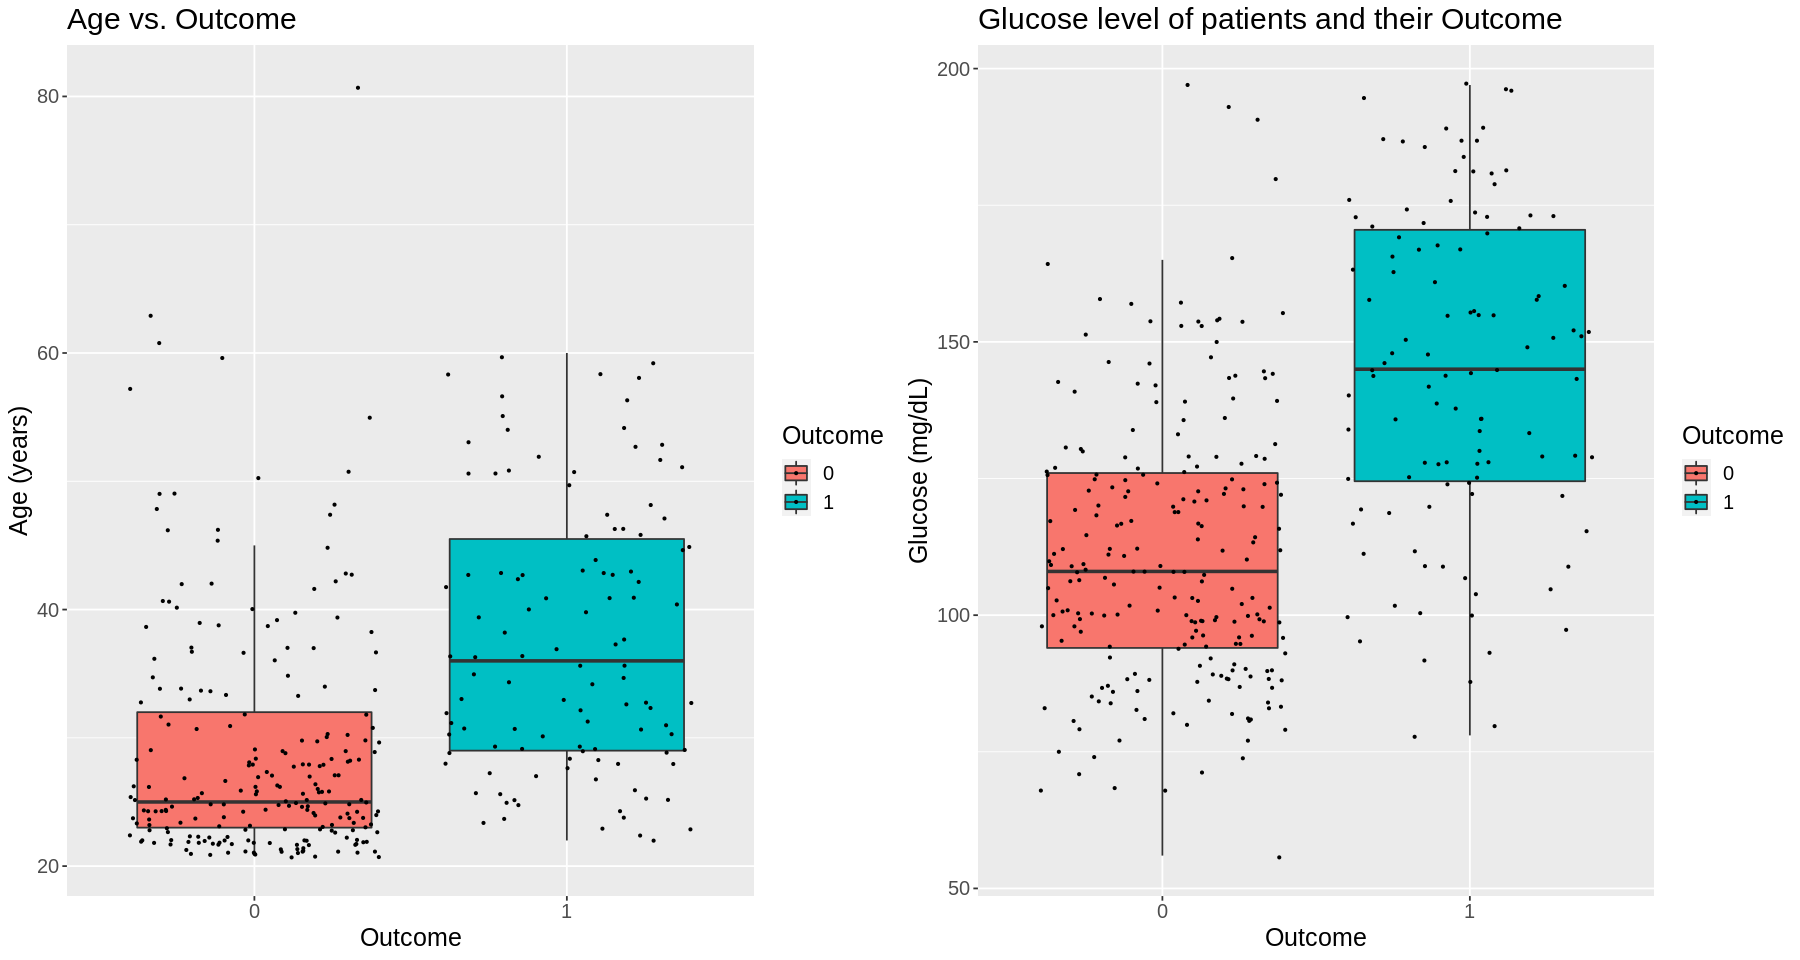

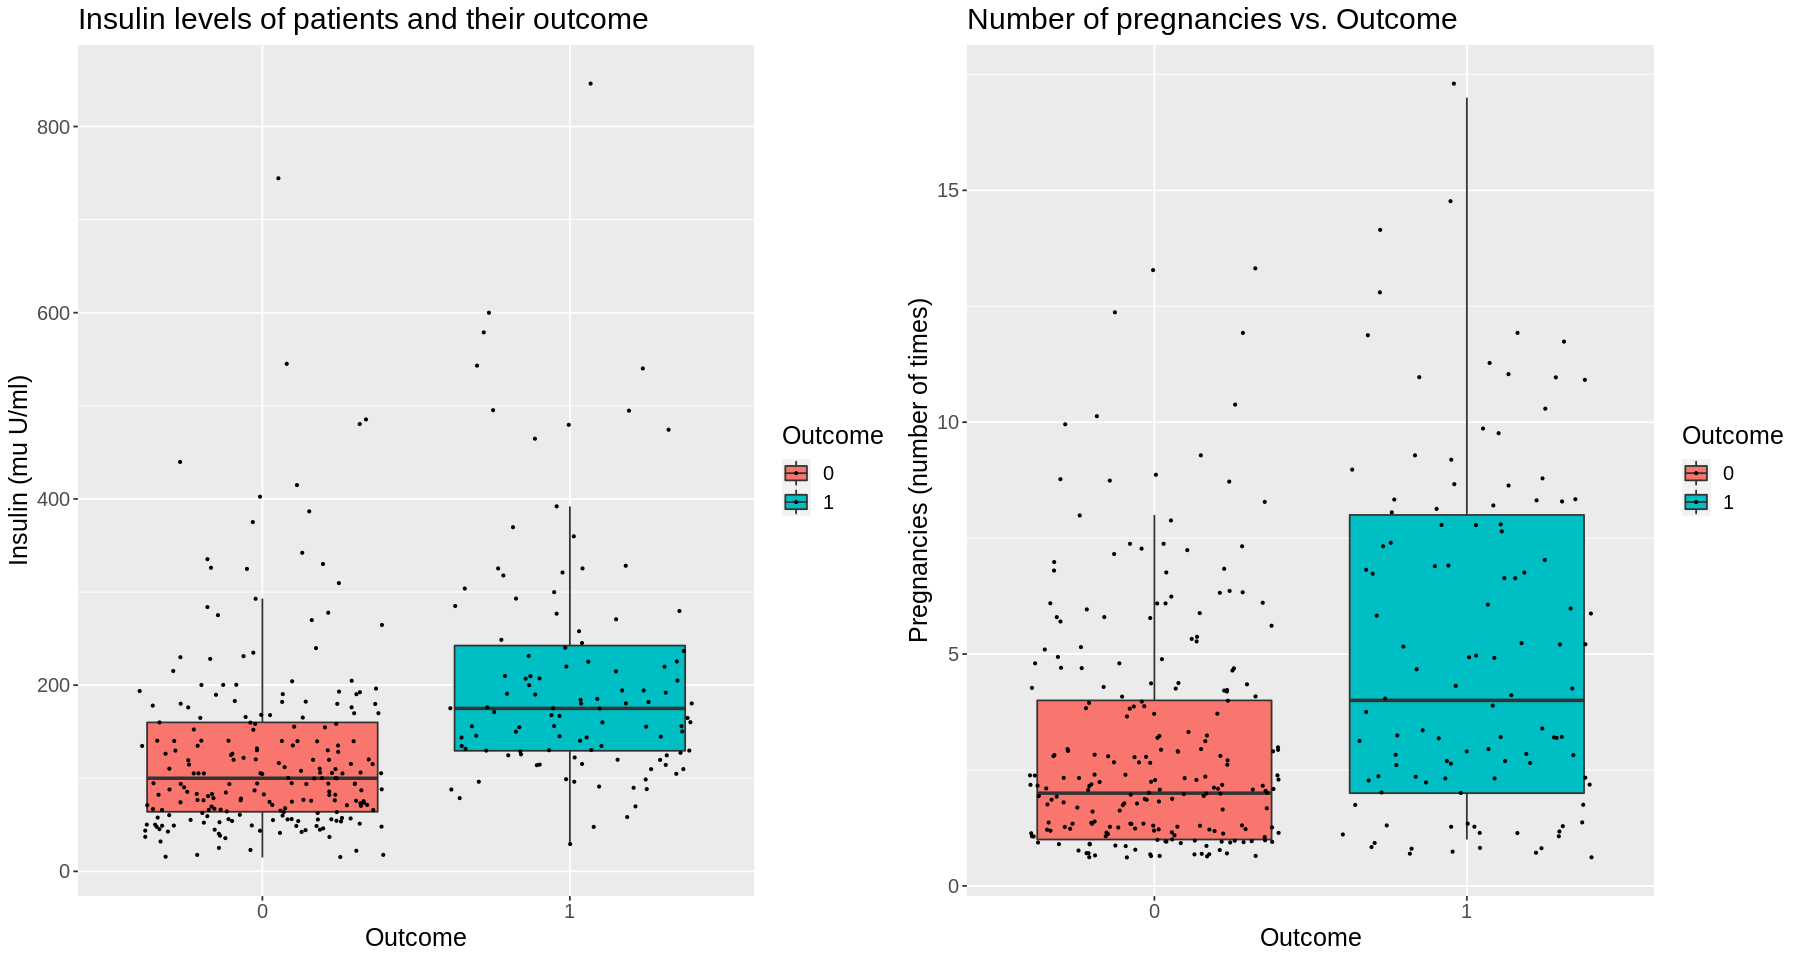

In [73]:
options(repr.plot.width = 15, repr.plot.height = 8)
#Plots for preliminary data analysis

#create plot for glucose vs. outcome
glucose_plot <- diabetes_data_processed |>
    ggplot(aes(x = Outcome, y = Glucose, fill = Outcome)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Glucose level of patients and their Outcome") +
        labs(x = "Outcome", y = "Glucose (mg/dL)") +
        theme(text = element_text(size = 15))
#create plot for age vs. outcome
age_plot <- diabetes_data_processed |>
    ggplot(aes(x = Outcome, y = Age, fill = Outcome)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Age vs. Outcome") +
        labs(x = "Outcome", y = "Age (years)") +
        theme(text = element_text(size = 15))
#create plot for insulin vs. outcome
insulin_plot <- diabetes_data_processed |>
    ggplot(aes(x = Outcome, y = Insulin, fill = Outcome)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Insulin levels of patients and their outcome") +
        labs(x = "Outcome", y = "Insulin (mu U/ml)") +
        theme(text = element_text(size = 15))
#create plot for pregnancies vs. outcome
pregnancies_plot <- diabetes_data_processed |>
    ggplot(aes(x = Outcome, y = Pregnancies, fill = Outcome)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Number of pregnancies vs. Outcome") +
        labs(x = "Outcome", y = "Pregnancies (number of times)") +
        theme(text = element_text(size = 15))

#Figure 2
print("Figure 2")
grid.arrange(age_plot, glucose_plot,
             layout_matrix = rbind(c(1, 2),
                                   c(1, 2)))

grid.arrange(insulin_plot, pregnancies_plot,
             layout_matrix = rbind(c(1, 2),
                                   c(1, 2)))

Based on these preliminary box plots, we observe that our chosen predictor variables: glucose, age, insulin, and pregnancies, are all good indicators for predicting diabetes. From analyzing these plots, we had a few notable findings:
- All the predictors have a positive relationship with "Outcome" as an increased value leads to a presence of diabetes while a decreased value leads to an absence of diabetes
- Glucose was the most distinct predictor as it showed the biggest differences in the presence and absence of diabetes
- Pregnancies was the least distinct predictor as it showed the smallest differences in the presence and absence of diabetes
- All of the plots show significant differences in outcomes which was analyzed by comparing the respective medians of each box plot to the interquartile range

### 2. Building the Classifier
#### Splitting the Data
To prepare our data for a classification analysis, we split the data set into our training and testing set. Our data has 336 rows of data so 75% of the dataset will give us approximately 250 observations which is suitable to train the model. We decided that having a larger training set would give a more accurate model as it gives a good balance between training an accurate model and obtaining an accurate evaluation of the model's performance, therefore the proportion of splitting the data will be 75%.

In [26]:
set.seed(1400)

#Split data set into training and testing set
diabetes_split <- initial_split(diabetes_data_processed, prop = 0.75, strata = Outcome)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

#### Finding Best K Value
In order to create the most accurate classification model, we need to find an optimal k value that will produce the maximum accuracy for our results. We start by setting up our model specification for a KNN classification and finding the optimal k value. The data is split into five equal chunks to perform a cross-validation and tune the model to obtain a higher accuracy. The recipe is created using the model specification that was found in the forward selection process from the previous section. We tested k values from 1 to 50 while skipping by 2, as any value larger than 50 would slow down the notebook. The recipe, model specification, and tuning process are all combined in a workflow to colect important metrics and finally filter for the accuracy.

In [85]:
#Create recipe based on model from forward selection
diabetes_recipe <- recipe(model, data = diabetes_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
diabetes_recipe

#Tune for model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#Choosing range of k values
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2)) 

#Performing cross-validation
diabetes_vfold <- vfold_cv(data = diabetes_train, v = 5, strata = Outcome)

#Putting everything into workflow
knn_tune_results <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
    collect_metrics()|>
    filter(.metric=="accuracy")|>
    arrange(desc(mean))

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

With the workflow complete, we visualize the accuracy versus k value using a line plot ("Figure 3") to determine which k value will yield the highest accuracy.

[1] "Figure 3"


[1] 31

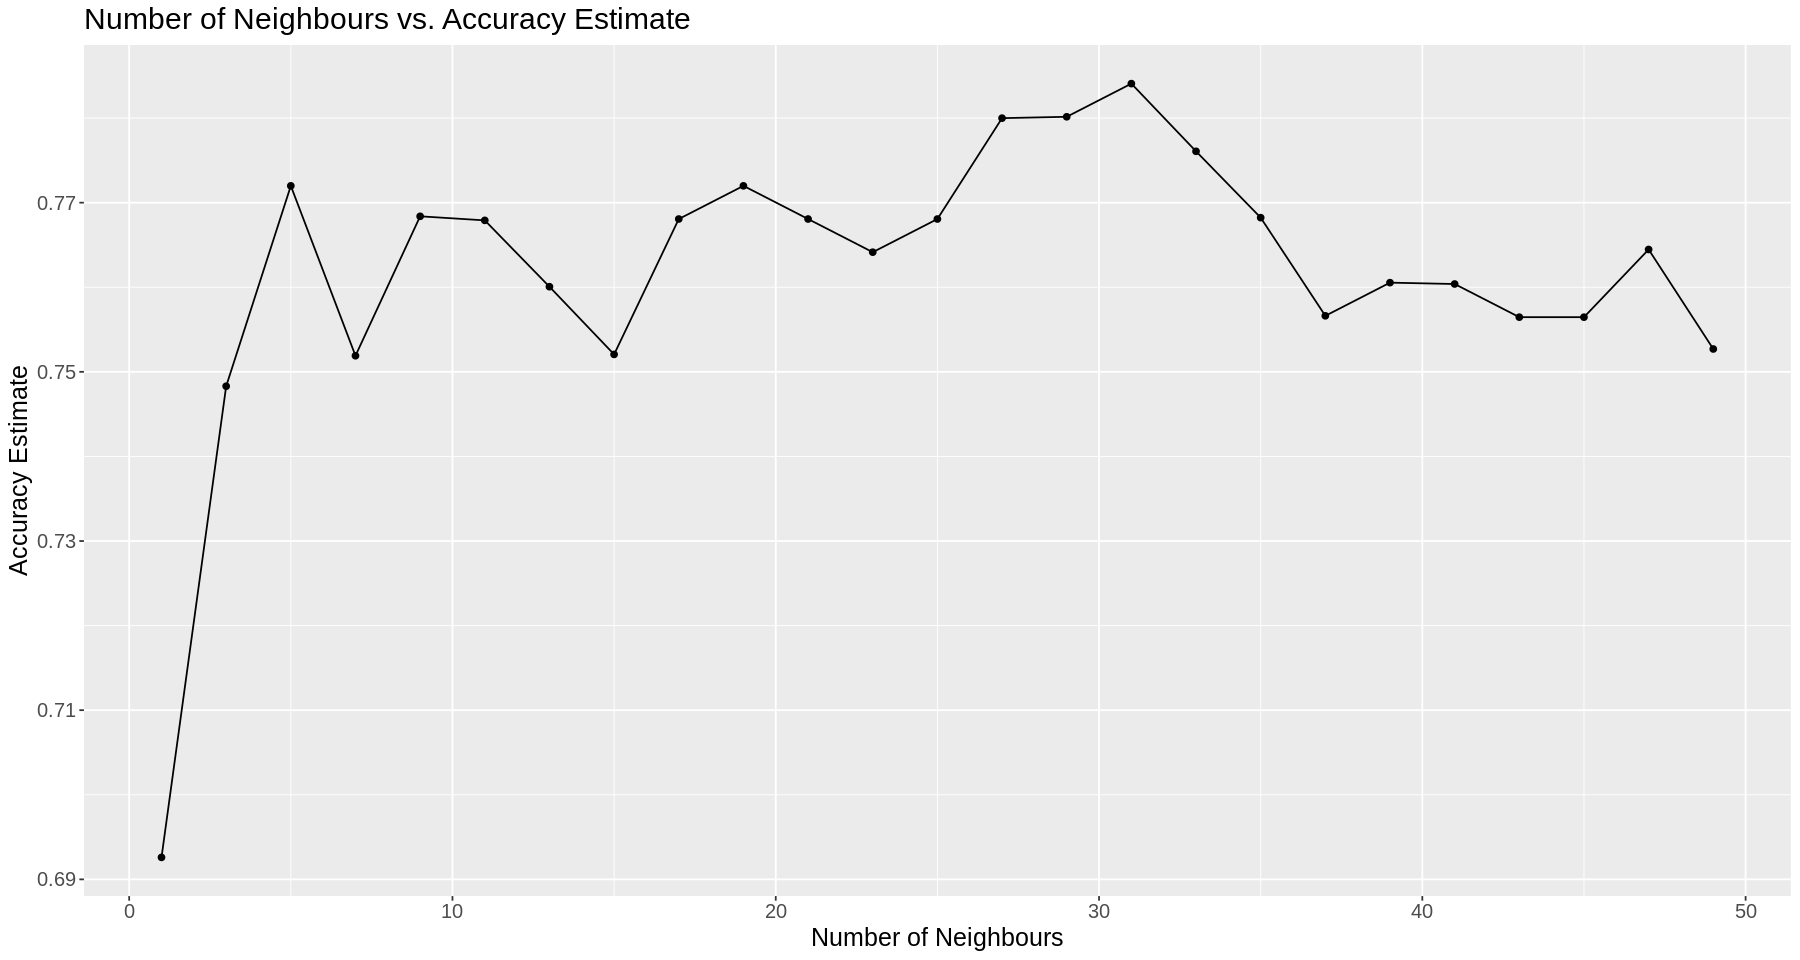

In [77]:
#Filter for accuracy
accuracies <- knn_tune_results |>
    filter(.metric == "accuracy")

#Create plot for number k neighbors vs. accuracy of model
accuracies_vs_k_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Number of Neighbours", y="Accuracy Estimate") +
    ggtitle("Number of Neighbours vs. Accuracy Estimate") +
    theme(text = element_text(size = 15))
#Figure 3
print("Figure 3")
accuracies_vs_k_plot

#Select best k value
best_k <- knn_tune_results |>
    slice(1)|>
    pull(neighbors)
best_k

From the plot above, we should use a k value of 31 because it gives us the highest accuracy estimate which means this is the number of neighbors we should use in our classification model. Changing the k value to another nearby number by plus or minus one does not change accuracy significantly which shows that the k value is reliable.

#### Evaluating Model Accuracy
Using the new k value, the model is retrained on the training data with the specified k value. We use the same recipe with the new model specification which is combined in workflow to form our final model. This model is evaluated by predicting the testing observations from the testing data. We gather summary statistics on the model to analyze the quality including the accuracy.

In [78]:
#Create new model specification with chosen k value
diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

#put everything back into workflow
diabetes_fit <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(diabetes_spec) |>
    fit(data = diabetes_train)

#Predict on testing data using model
diabetes_test_predictions <- diabetes_fit |>
    predict(diabetes_test) |>
    bind_cols(diabetes_test) 

#Summarize statistics and filter for accuracy
result_metrics <- diabetes_test_predictions |>
    metrics(truth = Outcome, estimate = .pred_class) |>
    filter(.metric == "accuracy")
#Table 5
print("Table 5")
result_metrics

[1] "Table 5"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7764706


From this, it can be seen that the accuracy of our classification model on the testing dataset is 78% which is a good accuracy level. This percentage will be further analyzed in the discussion section.

### 3. Final Visualization of Results
We will visualize the accuracy of our model with a heat map of the confusion matrix. This will allow us to evaluate the actual percentage of the model's accuracy based on how many cases it was able to predict correctly.

          Truth
Prediction  0  1
         0 50 12
         1  7 16

`summarise()` has grouped output by 'Outcome'. You can override using the
`.groups` argument.


[1] "Figure 4"


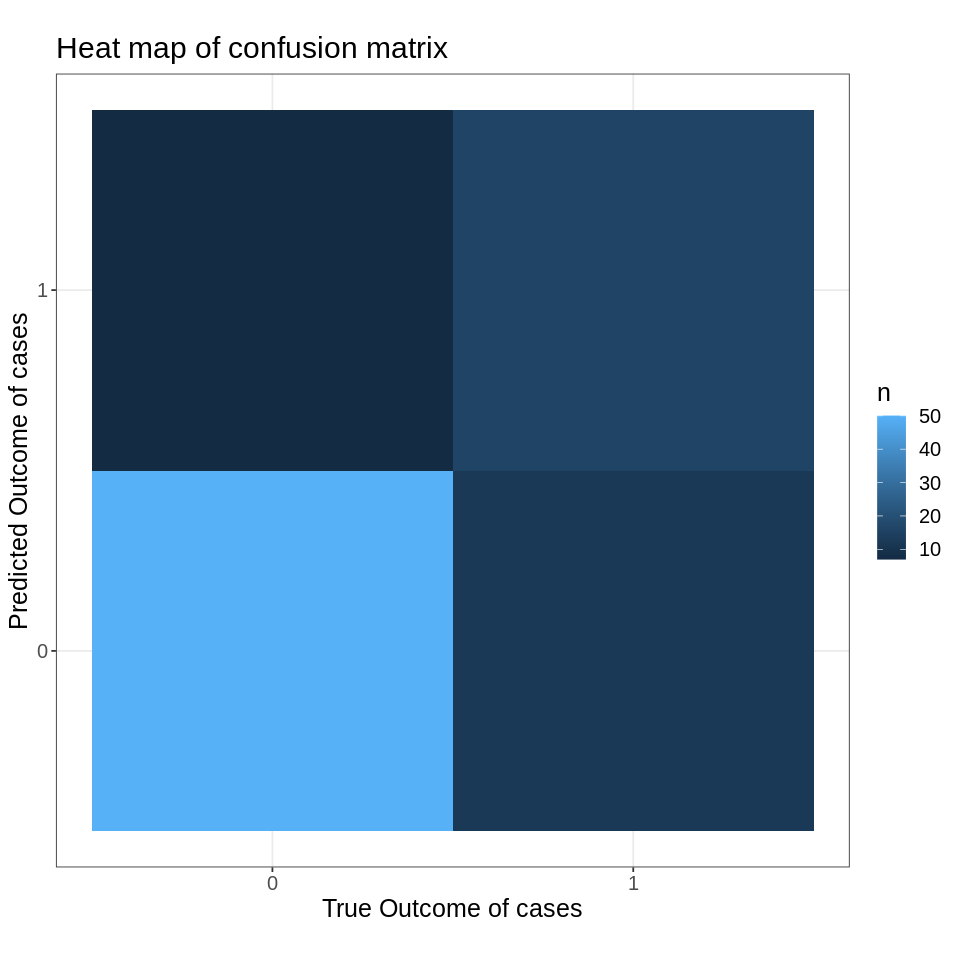

In [86]:
#confusion matrix
confmat <- diabetes_test_predictions |>
    conf_mat(truth = Outcome, estimate = .pred_class)
confmat

#summarize confusion matrix statistics
new_confmat <- diabetes_test_predictions |>
    select(.pred_class, Outcome) |>
    group_by(Outcome, .pred_class) |>
    summarize(n = n())

#Create heat map of confusion matrix
confmat_plot <- ggplot(new_confmat, aes(x = Outcome, y = .pred_class, fill = n)) +
    geom_tile() +
    theme_bw() +
    coord_equal() +
    labs(x = "True Outcome of cases", y = "Predicted Outcome of cases",
         title = "Heat map of confusion matrix") +
    theme(text = element_text(size = 15))
#Figure 4
print("Figure 4")
confmat_plot

As we can see from the confusion matrix plot above, the classification model has an accuracy of 78% which was calculated by dividing the true positives and true negatives by the total predictions. The model predicted 7 false positives and 12 false negatives which shows that it is very balanced in terms of predicting both the absence and presence of diabetes. There is a high number of correct predictions with 50 true negatives and 16 true positives. Overall, the heat map is a clear visualization of the accuracy of the model when predicting on a new data set and can be used to analyze the errors in predictions.

## Discussion: ##

## References ##

Diabetes Facts & Figures. International Diabetes Federation. (2021, September 12). Retrieved March 10, 2023 from https://idf.org/aboutdiabetes/what-is-diabetes/facts-figures.html#:~:text=The%20IDF%20Diabetes%20Atlas%20Tenth,and%20783%20million%20by%202045. 

What is Diabetes? Centers for Disease Control and Prevention. (2022, July 7). Retrieved March 11, 2023, from https://www.cdc.gov/diabetes/basics/diabetes.html#:~:text=Diabetes%20is%20a%20chronic%20(long,your%20pancreas%20to%20release%20insulin 

What is Diabetes? National Institute of Diabetes and Digestive and Kidney Diseases. (2016, December). Retrieved March 11, 2023, from https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes